# Chile2010b -- Example of gauges

This [Jupyter notebook](http://www.jupyter.org) can be found in [collection of Clawpack apps](http://www.clawpack.org/apps.html) as the file [`$CLAW/apps/notebooks/geoclaw/chile2010b/chile2010b.ipynb`](https://github.com/clawpack/apps/tree/master/notebooks/geoclaw/chile2010b/chile2010b.ipynb).  
To run this notebook, [install Clawpack](http://www.clawpack.org/installing.html), and clone the [apps repository](https://github.com/clawpack/apps).
A static view of this and other notebooks can be found in the [Clawpack Gallery of Jupyter notebooks](http://www.clawpack.org/gallery/notebooks.html).

This example starts with a `setrun.py` file similar to what resulted after working through the `$CLAW/apps/notebooks/geoclaw/chile2010a` example, with a couple changes:

 - The Level 3 grids are now refined by a factor of 6 relative to Level 2.
 - A gauge has been added at the location of [DART buoy 32412](http://www.ndbc.noaa.gov/station_page.php?station=32412).   DART (Deep Ocean Assessment and Reporting of Tsunamis) buoys transmit data from pressure gauges on the sea floor that can measure the water pressure accurately enough to detect long wave disturbances in the water surface level.  Data from this site has been de-tided and also saved in this directory, in the file `32412_notide.txt`.
 
In this example we will first run the code as it is set up to view the gauge results.

Then we will replace this with a gauge off the coast of Peru to better observe edge waves that are trapped on the continental shelf in this region.  We will also see a different way to specify output times for the animation, and how to work with gauge data in Python.

### Version

Animation revised 2020-04-09 to run with v5.7.0

## Notebook setup 

You can skip to **Exercise 1**

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from clawpack.clawutil import nbtools
from clawpack.visclaw import animation_tools
from IPython.display import HTML

In [3]:
def show_anim(anim):
    html_version = HTML(anim.to_jshtml())
#     html_version = HTML(anim.to_html5_video())
    return html_version

In [4]:
nbtools.make_exe(new=True,verbose=False)

Importing the pre-defined parameters (which can be changed either in the file or by calling a specific parameter in the notebook (see the Manning's coefficient call in this document as an example))

In [5]:
from setrun import setrun
from setrun_alt import setrun_alt

rundata = setrun()
rundata_alt = setrun_alt()

Function to write (any changes made by the user to) \*.data files, and then run the code from these files to create fortran data and images to be used in animation. 

In [6]:
def comp_data(out = False):
    # create *.data files from parameters in setrun.py
    rundata.write()
    # Run the code from the *.data files
    outdir,plotdir = nbtools.make_output_and_plots(verbose = out)
    
    rundata_alt.write()
    outdir_alt,plotdir_alt = nbtools.make_output_and_plots(label="_alt",verbose=out)
    return plotdir

Function to concatenate frames to be used in animation, then creating the user-facing animation. 

In [7]:
from PIL import Image

def stitch_anim(plotdir, exno = 1, figno = 0): 
    if exno == 1:
        frames = 5
        extra = ''
    elif exno == 2:
        frames = 19
        extra = 0
    else:
        print ("Enter the exercise you are running, either 1, or 2")
        
    for a in range(exno - 1 ,frames + 1):
        im = Image.open('/home/jack/clawpack_src/clawpack-v5.7.0/apps/notebooks/geoclaw/chile2010b/_plots/frame{:04d}fig{}.png'.format(a, figno))
        im_alt = Image.open('/home/jack/clawpack_src/clawpack-v5.7.0/apps/notebooks/geoclaw/chile2010b/_plots_alt/frame{:04d}fig{}.png'.format(a, figno))
        dst = Image.new('RGB', (im.width + im_alt.width, im.height))
        dst.paste(im, (0, 0))
        dst.paste(im_alt, (im.width, 0))
        dst.save('/home/jack/clawpack_src/clawpack-v5.7.0/apps/notebooks/geoclaw/chile2010b/_plots/frame{:04d}fig{}.png'.format(a, figno))
    anim = animation_tools.animate_from_plotdir(plotdir, figno)
    return show_anim(anim)

Choose your Manning's n values

In [8]:
mann_1 = 0.009
mann_2 = 0.15

rundata.geo_data.manning_coefficient = mann_1
rundata_alt.geo_data.manning_coefficient = mann_2

## Exercise 1

Run the code via `make .plots` and observe the results.  The animation titled "Full Domain" should look like this:

In [9]:
# plotdir = comp_data()
# stitch_anim(plotdir)

## Gauge plot

From the `_plots/_PlotIndex.html` page you can click on a figure that shows the gauge results.  You should see something like the plot below.  

Note that the file `setplot.py` contains the code that causes this plot to show the de-tided observations at the DART location (the red curve) along with the GeoClaw solution.  The first signal in the red curve is the seismic wave that is picked up by the pressure gauge at the DART location.  The seismic wave travels much faster than the tsunami and arrives about 3 hours earlier.

The GeoClaw result captures the main waves but none of the details.  This is partly because of the relatively coarse grid used for this example, but more because the earthquake source used in this example is not a very good representation of the actual earthquake.  Better source models are available, see [the documentation](http://www.clawpack.org/tsunamidata.html) for some links to other data, and the [this notebook](http://nbviewer.jupyter.org/url/clawpack.github.io/notebooks/dtopotools_examples.ipynb) for some information on how to work with this data in GeoClaw.

## Edge waves on the coast of Peru

The `setplot.py` file in this directory plots two figures each time frame.  One shows the whole domain, the animation above.  The second plot sets the axis limits so that it zooms in on the coast of Peru.  The animation produces should look like what is seen below.

In [10]:
# plotdir = comp_data()
# stitch_anim(plotdir, figno = 1)

Note that there are large waves (dark red and blue) that propagate up and down along the coast.  This is because the continental shelf along the coast here is fairly broad  and traps waves due to reflections at the steep continental slope.  This example is adapted from an Acta Numerica paper (by R.J. LeVeque, D.L. George, and M.J. Berger)  that describes the GeoClaw algorithms in some detail along with some basic tsunami science.  The paper and a more detailed  animation of these edge waves can be found at [http://www.clawpack.org/links/an11](http://depts.washington.edu/clawpack/links/an11/).

## Exercise 2.

To explore this in more detail, let's remove the DART gauge and instead put a gauge along the coast.  

In `setrun.py` replace the line

    rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10])
by

    rundata.gaugedata.gauges.append([123, -77.3, -12.3, 3.5*3600, 1.e10])
    
(Or you could include both lines, to record time series at both gauges).

The format of the list we are appending to the list of gauges is `[gaugeno, x, y, t1, t2]`.  Here we use `gaugeno = 123` which is an arbitray number (up to 5 digits) used to identify this gauge.  `x, y` are the longitude and latitude of the gauge location, and `t1, t2` specify the time range over which we want to record at this gauge.  In our case we start at 3.5 hours and go to `1e10` (effectively infinite, i.e. to the end of the computation).

### Changing the output times

We also want to go out to a later time to see the oscillations we expect at this gauge, and we want to output more frequently to see how they propagate in looking at the animation made from time frames.  But waves don't reach this coast until about 3.5 hours into the simulation, so rather than using equally spaced times from `t = 0`, let's use a different `output_style` that allows setting a specific set of output times:

Change the line

    clawdata.output_style = 1

to

    clawdata.output_style = 2
    
Note that in this case the `setrun.py` will execute the lines

    elif clawdata.output_style == 2:
        # Specify a list of output times.
        clawdata.output_times = np.linspace(3.5,8,19) * 3600.
        
which will specify 17 output frames, every 15 minutes from 3.5 hours to 8 hours.

Below we make the same changes in the notebook and show the resulting plots.

In [23]:
# Change output times:
rundata.clawdata.output_style = 2
rundata.clawdata.output_times = linspace(3.5,8,19) * 3600.

In [24]:
# Change gauge location:
from clawpack.amrclaw.data import GaugeData
rundata.replace_data("gaugedata", GaugeData())  # clear old gauge data
rundata.gaugedata.gauges = []   # empty list
rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10]) # original gauge
rundata.gaugedata.gauges.append([123, -77.3, -12.3, 3.5*3600, 1.e10]) # relocated gauge

now for alt

In [25]:
# Change output times:
rundata_alt.clawdata.output_style = 2
rundata_alt.clawdata.output_times = linspace(3.5,8,19) * 3600.

In [26]:
# Append additional guage location:
from clawpack.amrclaw.data import GaugeData
rundata_alt.replace_data("gaugedata", GaugeData())  # clear old gauge data
rundata_alt.gaugedata.gauges = []   # empty list
rundata_alt.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10]) # additional gauge
rundata_alt.gaugedata.gauges.append([123, -77.3, -12.3, 3.5*3600, 1.e10]) # relocated gauge

In [27]:
plotdir = comp_data()
# stitch_anim(plotdir, exno = 2, figno = 1)

Note that the way gauges work in GeoClaw is to output the elevation at this gauge (also momenta) at each time step, interpolating to each gauge location from the finest AMR grid available at this time in this region.  In this example we started recording at this gauge at time 3.5 hours, when there was already a Level 3 grid in this region.  If we had started recording earlier, this gauge might have been in a cell that was dry on a coarser grid (since it is so close to the coast) in which case the elevation of the land (possibly 10s or 100s of meters) would have been recorded at earlier times.  If you see big jump discontinuities in gauge plots, this is probably what is happening.  You can adjust the  time over which plotting is done in `setplot.py`.

## Viewing gauges in Python

The file `setplot.py` can be modified to plot different things at the gauges.  We don't do that here, and instead illustrate how to directly plot things in Python.  The file `plot_gauge123.py` in this directory also implements this. So if you type

    python plot_gauge123.py
    
two png files should be produced with plots similar to those shown below.

First we read the plot data from the most recent GeoClaw run:

RUN Exercise number 2 first (you do not need to animate it though)  

---
**MINE**

Here, we just need to change the plotdata outdir, and setplot to alt versions

getting data for gauge 123

In [37]:
from setplot import setplot
plotdata = setplot()
plotdata.outdir = '_output'
g123 = plotdata.getgauge(123)
plotdata.outdir = '_output_alt'
g123_alt = plotdata.getgauge(123)

Read in gauge 123.
Read in gauge 123.


getting data for gauge 32412

In [38]:
from setplot import setplot
plotdata = setplot()
plotdata.outdir = '_output'
g32412 = plotdata.getgauge(32412)
plotdata.outdir = '_output_alt'
g32412_alt = plotdata.getgauge(32412)

Read in gauge 32412.
Read in gauge 32412.


The object `g123` has an attribute `t` that is time in seconds, and `q` that contains columns corresponding to water depth, x-momentum, y-momentum, and eta = surface elevation.

Here's how we can make some plots:

---
**MINE** 

Here, instead of making a plot, we make 2 subplots, and put them side by side.

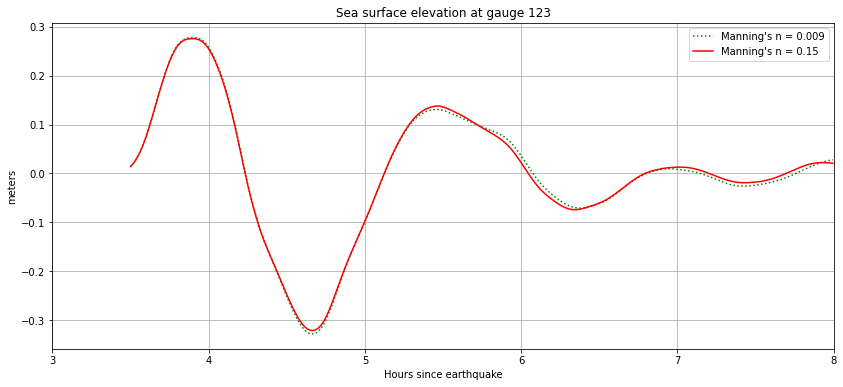

In [39]:
t = g123.t / 3600.  # convert to hours
eta = g123.q[3,:]   # eta = h + B (depth plus bathymetry)

t_alt = g123_alt.t / 3600.  # convert to hours
eta_alt = g123_alt.q[3,:]   # eta = h + B (depth plus bathymetry)

grid()
plot(t,eta,'g:',label="Manning's n = {}".format(mann_1))
plot(t_alt,eta_alt,'r',label="Manning's n = {}".format(mann_2))
legend()
xlim(3,8)
xlabel('Hours since earthquake')
ylabel('meters')
title('Sea surface elevation at gauge 123')

gcf().set_size_inches(14,6)
show()

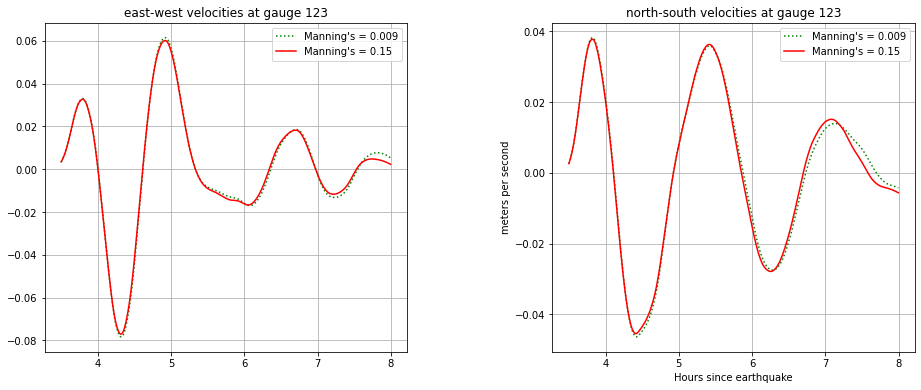

In [40]:
h = g123.q[0,:]       # water depth
u = g123.q[1,:] / h   # u = east-west velocity
v = g123.q[2,:] / h   # v = north-south velocity

h_alt = g123_alt.q[0,:]       # water depth
u_alt = g123_alt.q[1,:] / h_alt   # u = east-west velocity
v_alt = g123_alt.q[2,:] / h_alt   # v = north-south velocity

subplot(1, 2, 1)
grid()
plot(t,u,'g:',label="Manning's = {}".format(mann_1))
plot(t_alt,u_alt,'r',label="Manning's = {}".format(mann_2))
legend()
title('east-west velocities at gauge 123')
# xlabel('Hours since earthquake')
# ylabel('meters per second')

subplot(1, 2, 2)
grid()
plot(t,v,'g:',label="Manning's = {}".format(mann_1))
plot(t_alt,v_alt,'r',label="Manning's = {}".format(mann_2))
legend()
title('north-south velocities at gauge 123')
xlabel('Hours since earthquake')
ylabel('meters per second')

tight_layout()
gcf().set_size_inches(14,6)
show()

---
**MINE** 

Here, instead of making a plot, we make 2 subplots, and put them side by side.

In [41]:
from setplot import setplot
plotdata = setplot()
plotdata.outdir = '_output'
g32412 = plotdata.getgauge(32412)

Read in gauge 32412.


In [42]:
plotdata.outdir = '_output_alt'
g32412_alt = plotdata.getgauge(32412)

Read in gauge 32412.


The object `g32412` has an attribute `t` that is time in seconds, and `q` that contains columns corresponding to water depth, x-momentum, y-momentum, and eta = surface elevation.

Here's how we can make some plots:

---
**MINE** 

Here, instead of making a plot, we make 2 subplots, and put them side by side.

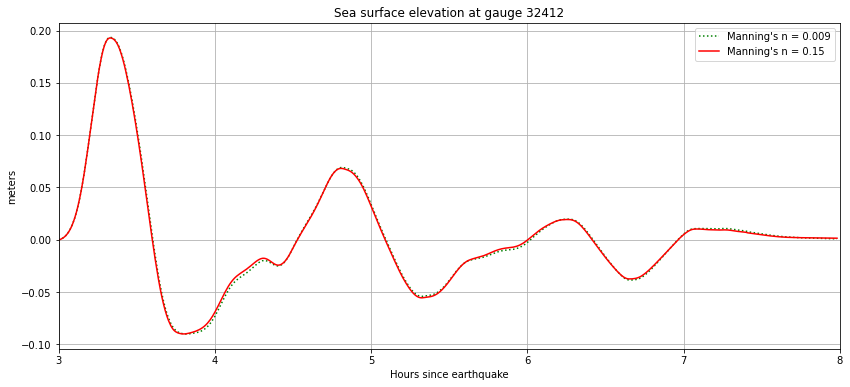

In [43]:
t = g32412.t / 3600.  # convert to hours
eta = g32412.q[3,:]   # eta = h + B (depth plus bathymetry)

t_alt = g32412_alt.t / 3600.  # convert to hours
eta_alt = g32412_alt.q[3,:]   # eta = h + B (depth plus bathymetry)

grid()
plot(t,eta,'g:',label="Manning's n = {}".format(mann_1))
plot(t_alt,eta_alt,'r',label="Manning's n = {}".format(mann_2))
legend()
xlim(3,8)
xlabel('Hours since earthquake')
ylabel('meters')
title('Sea surface elevation at gauge 32412')

gcf().set_size_inches(14,6)
show()

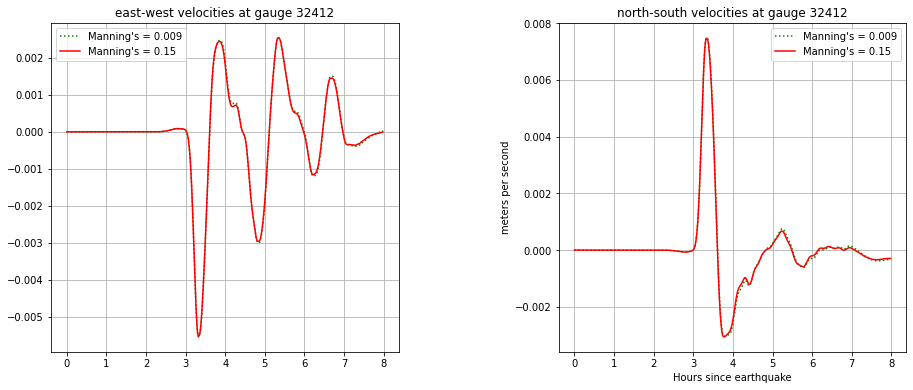

In [44]:
h = g32412.q[0,:]       # water depth
u = g32412.q[1,:] / h   # u = east-west velocity
v = g32412.q[2,:] / h   # v = north-south velocity

h_alt = g32412_alt.q[0,:]       # water depth
u_alt = g32412_alt.q[1,:] / h_alt   # u = east-west velocity
v_alt = g32412_alt.q[2,:] / h_alt   # v = north-south velocity

subplot(1, 2, 1)
grid()
plot(t,u,'g:',label="Manning's = {}".format(mann_1))
plot(t_alt,u_alt,'r',label="Manning's = {}".format(mann_2))
legend()
title('east-west velocities at gauge 32412')
# xlabel('Hours since earthquake')
# ylabel('meters per second')

subplot(1, 2, 2)
grid()
plot(t,v,'g:',label="Manning's = {}".format(mann_1))
plot(t_alt,v_alt,'r',label="Manning's = {}".format(mann_2))
legend()
title('north-south velocities at gauge 32412')
xlabel('Hours since earthquake')
ylabel('meters per second')

tight_layout()
gcf().set_size_inches(14,6)
show()

# TESTING AREA

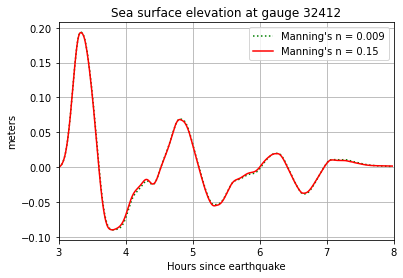

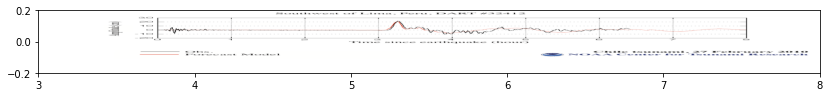

In [45]:
t = g32412.t / 3600.  # convert to hours
eta = g32412.q[3,:]   # eta = h + B (depth plus bathymetry)

t_alt = g32412_alt.t / 3600.  # convert to hours
eta_alt = g32412_alt.q[3,:]   # eta = h + B (depth plus bathymetry)

grid()
plot(t,eta,'g:',label="Manning's n = {}".format(mann_1))
plot(t_alt,eta_alt,'r',label="Manning's n = {}".format(mann_2))
legend()
xlim(3,8)
xlabel('Hours since earthquake')
ylabel('meters')
title('Sea surface elevation at gauge 32412')

import matplotlib.pyplot as plt
img = plt.imread('/home/jack/clawpack_src/clawpack-v5.7.0/geoclaw/examples/tsunami/chile2010/dart32412_comp-2.png')
fig, ax = plt.subplots()
ax.imshow(img)

# img = imread('/home/jack/clawpack_src/clawpack-v5.7.0/geoclaw/examples/tsunami/chile2010/dart32412_comp-2.png')

x = range(5)
ax.imshow(img, extent=[3, 8, -0.20, 0.20])
# plt.imshow(img,zorder=0)

# from matplotlib import cbook
# imageFile = cbook.get_sample_data('/home/jack/clawpack_src/clawpack-v5.7.0/geoclaw/examples/tsunami/chile2010/dart32412_comp-2.png')
# image = imread(imageFile)
# imshow(image)
                                  
gcf().set_size_inches(14,6)
show()
